In [1]:
import numpy as np 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.models import Model
import gym

In [2]:

from tqdm import tqdm
import os
import time 

In [3]:
epsilon = 1  
EPSILON_DECAY = 0.998 
MIN_EPSILON = 0.01

In [4]:
env = gym.make('LunarLander-v2')

In [9]:
class ActionValueNetwork:
    def __init__(self, network_config):
        self.state_dim = network_config.get("state_dim")
        self.num_hidden_units = network_config.get("num_hidden_units")
        self.num_actions = network_config.get("num_actions")
        self.step_size=network_config.get('step_size')
    def create_model(self):
        i = Input(shape=self.state_dim)
        x = Dense(256, activation='relu')(i)
        x = Dense(self.num_actions, activation='linear')(x)
        model = Model(i, x)
        model.compile(optimizer=Adam(lr=self.step_size),loss='mse')
        return model

In [10]:
class ReplayBuffer:
    def __init__(self, size, minibatch_size, seed):
     
        self.buffer = []
        self.minibatch_size = minibatch_size
        self.rand_generator = np.random.RandomState(seed)
        self.max_size = size

    def append(self, state, action, reward, terminal, next_state):
      
        if len(self.buffer) == self.max_size:
            del self.buffer[0]
        self.buffer.append([state, action, reward, terminal, next_state])

    def sample(self):
      
        idxs = self.rand_generator.choice(np.arange(len(self.buffer)), size=self.minibatch_size)
        return [self.buffer[idx] for idx in idxs]

    def size(self):
        return len(self.buffer)

In [11]:

class Agent:
    def __init__(self, agent_config):
  
        
        self.replay_buffer = ReplayBuffer(agent_config['replay_buffer_size'], 
                                          agent_config['minibatch_sz'], agent_config.get("seed"))
        self.network = ActionValueNetwork(agent_config['network_config'])
        
        self.model=self.network.create_model()
        
        self.target_model=self.network.create_model()
        
        self.num_actions = agent_config['network_config']['num_actions']
        
        self.num_replay = agent_config['num_replay_updates_per_step']
        self.discount = agent_config['gamma']
        
        self.rand_generator = np.random.RandomState(agent_config.get("seed"))
        
        self.last_state = None
        self.last_action = None
        self.epsilon = epsilon
        self.sum_rewards = 0
        self.episode_steps = 0

    
    def policy(self, state):
     
        action_values =self.model.predict(state)
        if (np.random.uniform() < self.epsilon) or (action_values.all() == 0):
            action = np.random.randint(0, env.action_space.n)
        else:
            action=np.argmax(action_values)
        return action

    
    def agent_start(self):
       
        
        self.sum_rewards = 0
        self.episode_steps = 0
        self.last_state = env.reset()
        self.last_state = np.reshape(self.last_state,(-1,self.last_state.shape[0]))
        self.last_action = self.policy(self.last_state)
        return self.last_action


    def agent_step(self, state,reward,terminal):
      
        
        self.sum_rewards += reward
        self.episode_steps += 1
        
        state = np.array([state])

     
        action = self.policy(state)
       
       

       
        self.replay_buffer.append(self.last_state, self.last_action, reward, terminal, state)
        
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
            self.target_model.set_weights(self.model.get_weights())
            for _ in range(self.num_replay):
                experiences = self.replay_buffer.sample()
                self.agent_train(experiences)
        
        self.last_state = state
        self.last_action = action
       
        
        return action

    
    def agent_train(self,experiences):
        states, actions, rewards, terminals, next_states = map(list, zip(*experiences))
        states = np.concatenate(states)
        next_states = np.concatenate(next_states)
        rewards = np.array(rewards)
        terminals = np.array(terminals)
        batch_size1 = states.shape[0]
        q_next_mat = self.target_model.predict(next_states)
        
        v_next_vec = np.max(q_next_mat, axis=1)*(1-terminals)
        
        target_vec = rewards + self.discount*v_next_vec
       
        q_mat = self.model.predict(states)
      
        batch_indices = np.arange(q_mat.shape[0])

        X=states
        q_mat[batch_indices,actions] = target_vec
 
        self.model.fit(X,q_mat,batch_size=batch_size1,verbose=0,shuffle=False)
        
    def agent_message(self, message):
        if message == "get_sum_reward":
            return self.sum_rewards
        else:
            raise Exception("Unrecognized Message!")
    

In [12]:
agent_info = {
             'network_config': {
                 'state_dim': 8,
                 'num_actions': 4,
                 'step_size':1e-4
             },
             'replay_buffer_size': 50000,
             'minibatch_sz': 64,
             'num_replay_updates_per_step': 4,
             'gamma': 0.99,
             'seed': 0}
EPISODES = 300

In [13]:
agent=Agent(agent_info)

In [14]:
reward_episode=[]
no_episodes=[]
episode_steps=[]
eps_history=[]

In [15]:
for episode in range(1,300):
    action=agent.agent_start()
    terminal=0
    while terminal!=1:
        state,reward,terminal,info=env.step(action)
        if terminal==True:
            terminal=1
        else:
            terminal=0
        action=agent.agent_step(state,reward,terminal)
        if agent.epsilon > MIN_EPSILON:
            agent.epsilon *= EPSILON_DECAY
            agent.epsilon = max(MIN_EPSILON,agent.epsilon)
    reward = agent.agent_message('get_sum_reward')
    reward_episode.append(reward)
    no_episodes.append(episode)
    episode_steps.append(agent.episode_steps)
    eps_history.append(agent.epsilon)
    print('episode: ', episode,'score: ',reward,
            'epsilon %.2f' % agent.epsilon, 'steps', agent.episode_steps)

episode:  1 score:  -82.86096980509038 epsilon 0.87 steps 67
episode:  2 score:  -408.7319410123178 epsilon 0.68 steps 128
episode:  3 score:  -12.636956026504308 epsilon 0.40 steps 259
episode:  4 score:  -243.1418633435479 epsilon 0.32 steps 112
episode:  5 score:  -244.781969505036 epsilon 0.26 steps 101
episode:  6 score:  -73.02525786877096 epsilon 0.04 steps 1000
episode:  7 score:  -247.44965259057446 epsilon 0.03 steps 160
episode:  8 score:  -461.2986320280418 epsilon 0.01 steps 664
episode:  9 score:  -113.86727006799913 epsilon 0.01 steps 176
episode:  10 score:  -148.10590774680423 epsilon 0.01 steps 154
episode:  11 score:  -146.6266507020938 epsilon 0.01 steps 157
episode:  12 score:  -332.68656160579934 epsilon 0.01 steps 148
episode:  13 score:  -202.49356306361813 epsilon 0.01 steps 119
episode:  14 score:  -261.47335972444415 epsilon 0.01 steps 134
episode:  15 score:  -156.15266768693374 epsilon 0.01 steps 133
episode:  16 score:  -275.6166194478642 epsilon 0.01 step

episode:  130 score:  -195.98239931404856 epsilon 0.01 steps 1000
episode:  131 score:  -169.0738862078557 epsilon 0.01 steps 537
episode:  132 score:  -151.20291322349058 epsilon 0.01 steps 1000
episode:  133 score:  -162.57001655365465 epsilon 0.01 steps 1000
episode:  134 score:  -173.16683622810135 epsilon 0.01 steps 1000
episode:  135 score:  -167.03662114686296 epsilon 0.01 steps 418
episode:  136 score:  -166.57808719579268 epsilon 0.01 steps 1000
episode:  137 score:  -116.79641204774036 epsilon 0.01 steps 274
episode:  138 score:  -181.26496416774273 epsilon 0.01 steps 1000
episode:  139 score:  -165.37271117884674 epsilon 0.01 steps 1000
episode:  140 score:  -153.87694933861835 epsilon 0.01 steps 304
episode:  141 score:  -124.91191128781647 epsilon 0.01 steps 206
episode:  142 score:  -120.4564277834858 epsilon 0.01 steps 1000
episode:  143 score:  -247.08123635094182 epsilon 0.01 steps 671
episode:  144 score:  -137.1244139205737 epsilon 0.01 steps 1000
episode:  145 score

KeyboardInterrupt: 

In [18]:
import matplotlib.pyplot as plt

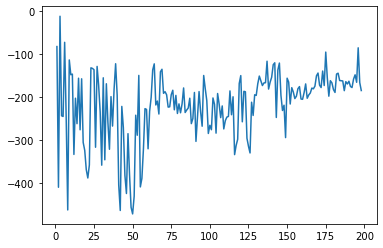

In [19]:
plt.plot(no_episodes,reward_episode)

In [20]:
reward_episode

[-82.86096980509038,
 -408.7319410123178,
 -12.636956026504308,
 -243.1418633435479,
 -244.781969505036,
 -73.02525786877096,
 -247.44965259057446,
 -461.2986320280418,
 -113.86727006799913,
 -148.10590774680423,
 -146.6266507020938,
 -332.68656160579934,
 -202.49356306361813,
 -261.47335972444415,
 -156.15266768693374,
 -275.6166194478642,
 -157.50637991603406,
 -304.93126031090924,
 -323.2963173239429,
 -367.84180544397,
 -387.2582533538965,
 -357.04357159631667,
 -132.09577592795043,
 -133.4887654892783,
 -136.41711760821113,
 -316.06760471714347,
 -128.85833717577455,
 -172.460249469935,
 -234.21054894854825,
 -357.5918819965701,
 -155.2172351364016,
 -345.19288409348263,
 -169.01390616195243,
 -258.2564890847236,
 -320.7733067211698,
 -198.8215327105583,
 -267.02693159993237,
 -181.6088875387615,
 -122.64983421778972,
 -195.5804291355058,
 -403.26821546775875,
 -462.50345368949644,
 -221.47864553174594,
 -270.702308272169,
 -380.8799669902027,
 -423.2206159279787,
 -284.6002270638

In [21]:
episode_steps

[67,
 128,
 259,
 112,
 101,
 1000,
 160,
 664,
 176,
 154,
 157,
 148,
 119,
 134,
 133,
 172,
 122,
 141,
 107,
 108,
 101,
 124,
 120,
 128,
 102,
 95,
 150,
 153,
 110,
 131,
 148,
 122,
 111,
 203,
 329,
 243,
 365,
 633,
 390,
 340,
 852,
 168,
 427,
 193,
 148,
 91,
 180,
 116,
 253,
 101,
 144,
 397,
 175,
 159,
 250,
 158,
 185,
 1000,
 466,
 651,
 622,
 449,
 273,
 207,
 356,
 483,
 523,
 251,
 256,
 352,
 1000,
 308,
 362,
 420,
 432,
 268,
 372,
 281,
 377,
 228,
 271,
 392,
 210,
 333,
 427,
 277,
 256,
 497,
 399,
 334,
 684,
 261,
 259,
 259,
 471,
 330,
 347,
 364,
 595,
 719,
 670,
 404,
 510,
 597,
 394,
 474,
 460,
 386,
 598,
 512,
 519,
 498,
 356,
 550,
 425,
 773,
 807,
 719,
 268,
 169,
 771,
 516,
 478,
 795,
 818,
 837,
 1000,
 833,
 1000,
 1000,
 537,
 1000,
 1000,
 1000,
 418,
 1000,
 274,
 1000,
 1000,
 304,
 206,
 1000,
 671,
 1000,
 1000,
 377,
 534,
 1000,
 753,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1